<a href="https://colab.research.google.com/github/hegdenischay/NEURONNet/blob/main/Full%20Network/Latest_Complete%20Network_Sensors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
size =   15#@param {type:"integer"}
dimension = "High" #@param ["High", "Low"]
epochs =  20 #@param {type:"integer"}
A_plus = 0.01 #@param {type:"number"}
A_minus = -0.0011 #@param {type: "number"}
lateralDelay = 5 #@param {type: "number"}

In [2]:
#@title Parameters
from ipywidgets import FloatText, Checkbox, VBox, Dropdown
import ipywidgets as widgets

currentAmp = FloatText(description='Amplitude:', value=0.1)
sets = FloatText(description='sets:', value=15)
noiseSD = FloatText(description='noiseSD:', value=0.01)

vb = VBox(children = [currentAmp, sets])
with_noise = Checkbox(description='Add noise')

def add_noise(button):
    if button['new']:
        vb.children = [currentAmp, sets, noiseSD]
    else:
        vb.children = [currentAmp, sets]

with_noise.observe(add_noise, names='value')
display(with_noise)
display(vb)

Checkbox(value=False, description='Add noise')

In [3]:
#@title Distribution
from ipywidgets import FloatText, Checkbox, VBox, Dropdown
import ipywidgets as widgets

distribution = Dropdown(description='distribution:', options=["uniform", "normal", "poisson"], value="uniform")
low = FloatText(description='low:', value=1)
high = FloatText(description='high:', value=1.5)
leng = FloatText(description='size:', value=sets.value)
mean = FloatText(description='mean:', value=1)
sd = FloatText(description='SD:', value=0.5)
lam = FloatText(description='lam', value=3)

vb2 = VBox(children = [low, high, leng])

def change_widgets(button):
    if button['new'] == "uniform":
        vb2.children = [low, high, leng]
    elif button['new'] == "normal":
        vb2.children = [mean, sd, leng]
    elif button['new'] == "poisson":
        vb2.children = [lam, sets]

distribution.observe(change_widgets, names='value')
display(distribution)
display(vb2)

Dropdown(description='distribution:', options=('uniform', 'normal', 'poisson'), value='uniform')

### Install Neuron

In [4]:
pip install pandas neuron hfda

Note: you may need to restart the kernel to use updated packages.


In [5]:
# %load_ext google.colab.data_table
# import pandas
# data = {'Time taken': ['5 sets (with learning)', '5 sets (without learning)', '30 sets (with learning)', '30 sets (without)'], 'Time (s)': [64.94386959075928, 64.94386959075928-47.318169593811035, 163.1467843055725, 163.1467843055725-123.22148942947388]}  
# pandas.DataFrame(data)

### Import prerequisites

In [7]:
import time
totalstart = time.time()
import os
# download from git
import shutil, requests
url = 'https://cloud.operationtulip.com/s/t8nbn8Y582w94P3/download/git.zip'
response = requests.get(url, stream=True)
with open('git.zip', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)
del response
import zipfile
with zipfile.ZipFile('git.zip', 'r') as zip_ref:
    zip_ref.extractall('')


In [8]:
!nrnivmodl &>/dev/null

In [9]:
from neuron import h #.h is a HOC object instance & gui from neuron can also be imported 
from math import pi                  
from neuron.units import ms,mV
from hebb_test import ORN, MCELL, GCELL
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
pc = h.ParallelContext()
import random  
import matplotlib.pyplot as plt1

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()

import seaborn as sns

Loading BokehJS ...

In [10]:
# import csv
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# !ls /content/drive/MyDrive/csvs/rose_natural/rose_nat.csv

In [12]:
# import pandas as pd
# df = pd.read_csv('/content/drive/MyDrive/csvs/orange_artificial/art_orange_day1(1).csv')

## Helper Functions

In [13]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200, noise: list = []) -> list:
    # duration and max_duration are in ms
    ans = [lo if i < duration else hi for i in range(0,max_duration)]
    if len(noise) == 0:
        return ans
    else:
        assert len(ans) == len(noise)
        return [ans[i]+noise[i] for i in range(len(ans))]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]
    # visualize input 

In [14]:
def netConMaker(source, dest, weights, delay, threshold, place='axon', type='exc'):
    # print(source, dest)
    if place == 'axon':
        if type == 'exc':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendexcisyn, sec=source.axon)
        elif type == 'inh':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendinhisyn, sec=source.axon)
    elif place == 'soma':
        if type == 'exc':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendexcisyn, sec=source.soma)
        elif type == 'inh':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendinhisyn, sec=source.soma)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [15]:
def latConMaker(source, dest, weights, delay, threshold, type='exc'):
    if type == 'exc':
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendexcisyn, sec=source.dend)
    else:
        netcon = h.NetCon(source.dend(0.5)._ref_v, dest.dendinhisyn, sec=source.dend)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [16]:
%matplotlib inline
def plotCell(source, name, addendum=''):
    recording_cell = source
    cell_axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
    cell_dend = h.Vector().record(recording_cell.dend(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    h.finitialize(-70 * mV)
    h.continuerun(300 * ms)

    f = plt1.figure(figsize=(16,9))
    ax = f.add_subplot(1,1,1)
    ax.plot(t, list(cell_axon), label=name+' axon '+addendum)
    ax.plot(t, list(cell_dend), label=name+' dendrite '+addendum)
    ax.legend(loc="upper right")
    ax.set_xlabel('t (ms)')
    ax.set_ylabel('v (mV)')
    plt1.show()

In [17]:
import math
def generate_L_weight_delta(first, second):
    A_plus = 0.01
    A_minus = -0.011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

In [18]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

## Network Definitions

In [19]:
class AON:
    def __init__(self,M,weights,delay1=1,delay2=2,delay3=3,delay4=4):
        wMM=weights[0]
        wMG=weights[1]
        wGM=weights[2]
        wGG=weights[3]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 5

        self.M1=MCELL(1,self.M)
        self.M2=MCELL(2,self.M)
        self.G1=GCELL(3,self.M)
        self.G2=GCELL(4,self.M)
        self.cells = [self.M1, self.M2, self.G1, self.G2]
        
        self.nc0 = netConMaker(self.M1, self.M2, wMM, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to E2
        self.nc1 = netConMaker(self.M2, self.M1, wMM, delay2+self.maindelay, self.th, 'soma') #Connecting E2 to E1
        self.nc2 = netConMaker(self.M2, self.G1, wMG, delay2+self.maindelay, self.th, 'soma') #Connecting E2 to I1
        self.nc3 = netConMaker(self.G1, self.M2, wGM, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to E2
        self.nc4 = netConMaker(self.G1, self.G2, wGG, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to I2
        self.nc5 = netConMaker(self.G2, self.G1, wGG, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting I2 to I1
        self.nc6 = netConMaker(self.G2, self.M1, wGM, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting I2 to E1
        self.nc7 = netConMaker(self.M1, self.G2, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to I2
        self.nc8 = netConMaker(self.M1, self.G1, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to I1
        self.nc9 = netConMaker(self.G1, self.M1, wGM, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to E1

In [20]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=0,delay2=2,delay3=4,delay4=6):
        wMM=weights[0]
        wMG=weights[1]
        wGM=weights[2]
        wGG=weights[3]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 5
        
        #Making 2 neurons
        self.orn = ORN(1,self.M)
        self.P1=MCELL(2,self.M)
        self.P2=MCELL(3,self.M)
        self.cells = [self.orn, self.P1, self.P2]
        
        #Giving current pulse
        self.stim = h.IClamp(self.orn.dend(0.5))  #P1.soma to P1.dend
        # self.stimArr = [h.IClamp(self.orn.ciliumArr[i](0.5)) for i in range(len(self.orn.ciliumArr))]
        if with_noise.value == True:
            self.noise = np.random.normal(0, noiseSD.value, 100)
            self.input = [i/(752700.235578777) for i in df[sensor]]
            self.tv = h.Vector([i for i in range(len(df[sensor]))])
            self.stim.delay = 10
            self.stim.dur = len(df[sensor])
            self.stim.amp = 0
            self.input.play(self.stim._ref_amp, self.tv, True) 
        else:
            self.stim.delay = 10
            self.stim.dur = 100
            self.stim.amp = currentAmp.value
        
        self.nc0 = netConMaker(self.orn, self.P1, wMM, self.maindelay+delay2, self.th, 'soma') #Connecting ORN to P1
        self.nc1 = netConMaker(self.P1, self.P2, wMM, self.maindelay+delay3, self.th, 'soma') #Connecting P1 to P2
        self.nc2 = netConMaker(self.P2, self.P1, wMM, self.maindelay+delay3, self.th, 'soma') #Connecting P2 to P1
    
        # 4-coupled

        self.M1=MCELL(1,self.M)
        self.M2=MCELL(2,self.M)
        self.G1=GCELL(3,self.M)
        self.G2=GCELL(4,self.M)
        self.cells.extend([self.M1, self.M2, self.G1, self.G2])

        self.nc14 = netConMaker(self.orn, self.M1, wMM, delay1+self.maindelay, self.th, 'soma')
        self.nc3 = netConMaker(self.P1, self.M1, wMM, delay1+self.maindelay, self.th, 'soma')
        self.nc4 = netConMaker(self.M1, self.M2, wMM, delay2+self.maindelay, self.th, 'soma') #Connecting M1 to M2
        self.nc5 = netConMaker(self.M2, self.M1, wMM, delay2+self.maindelay, self.th, 'soma') #Connecting M2 to M1
        self.nc6 = netConMaker(self.M2, self.G1, wMG, delay2+self.maindelay, self.th, 'soma') #Connecting M2 to G1
        self.nc7 = netConMaker(self.G1, self.M2, wGM, delay2+self.maindelay, self.th, 'soma', type='inh') #Connecting G1 to M2
        self.nc8 = netConMaker(self.G1, self.G2, wGG, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting G1 to G2
        self.nc9 = netConMaker(self.G2, self.G1, wGG, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting G2 to G1
        self.nc10 = netConMaker(self.G2, self.M1, wGM, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting G2 to M1
        self.nc11 = netConMaker(self.M1, self.G2, wMG, delay4+self.maindelay, self.th, 'soma') #Connecting M1 to G2
        self.nc12 = netConMaker(self.M1, self.G1, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting M1 to G1
        self.nc13 = netConMaker(self.G1, self.M1, wGM, delay1+self.maindelay, self.th, 'soma', type='inh') #Connecting G1 to M1

In [21]:

class LATERAL:
    """Laterally coupling N-2 coupled neurons
    """
    def __init__(self,N,weights,delay1=0,delay2=2,delay3=4,delay4=6):
        wMML=weights[1]
        wGGL=weights[5]
        
        self.N = N
        self.th = -70
        self.maindelay = lateralDelay
        self.sets = [CONNECTING(i, weights) for i in range(N)]
            
        self.twoCupArr = []
        for r in range(0,N-1):
          #Connecting P1[0] to P1[1]
          # make a list for easier access
          netConList = []
          netConList.append(latConMaker(self.sets[r].P1, self.sets[r+1].P1,wMML,self.maindelay+delay2,self.th)) #P1[0] to P1[1]
          netConList.append(latConMaker(self.sets[r+1].P1, self.sets[r].P1, wMML, self.maindelay+delay2,self.th))

          self.twoCupArr.append(netConList)
        self.fourCupArr = []
        for r in range(1,N-1):
            for j in range(N-r):
                netConList = []
                netConList.append(latConMaker(self.sets[j].M1, self.sets[j+r].M1, wMML, self.maindelay+delay3, self.th)) #Connect M1[0] to M1[1]
                netConList.append(latConMaker(self.sets[j+r].M1, self.sets[j].M1, wMML, self.maindelay+delay3, self.th)) #Connect M1[1] to M1[0]
                netConList.append(latConMaker(self.sets[j].G1, self.sets[j+r].G1, wGGL, self.maindelay+delay2, self.th, 'inh')) #Connecting G1[0] to G1[1]
                netConList.append(latConMaker(self.sets[j+r].G1, self.sets[j].G1, wGGL, self.maindelay+delay2, self.th, 'inh')) #Connecting G1[1] to G1[0]
                self.fourCupArr.append(netConList)

        # add AON and PC
        self.AON = AON(5,weights)
        self.PC = AON(6,weights)
        self.DPC = GCELL(7,self.N)
        # add noise to AON's M1
        self.stim = h.IClamp(self.AON.M1.dend(0.5))  #P1.soma to P1.dend
        self.noise = np.random.normal(0, 0.1, 100)
        self.input = h.Vector(self.noise)
        self.tv = h.Vector([i for i in range(100)])
        self.input.play(self.stim._ref_amp, self.tv, True)
        self.otherNetCons = []
        self.otherNetCons.append(netConMaker(self.sets[0].M1, self.AON.M1, wMML, self.maindelay+delay2, self.th, 'soma')) # 4-coupled M1 -> AON's E1
        for i in self.sets:
            for j in self.sets:
                if i != j:
                    self.otherNetCons.append(netConMaker(i.P1, j.P1, wMML, self.maindelay+delay2, self.th, 'soma')) # all-to-all in P1
                    self.otherNetCons.append(netConMaker(i.M1, j.M1, wMML, self.maindelay+delay3, self.th, 'soma')) # all-to-all in M1
                    self.otherNetCons.append(netConMaker(i.G1, j.G1, wGGL, self.maindelay+delay2, self.th, 'soma')) # all-to-all in M1

        for i in self.sets:
            self.otherNetCons.append(netConMaker(self.AON.M1, i.P2, wMML, self.maindelay+delay2, self.th, 'soma')) # AON E1 -> 2-coupled P2
        if dimension == "High":
            self.otherNetCons.append(netConMaker(self.PC.M1, self.AON.G1, wMML, self.maindelay+delay3+10, self.th, 'soma')) # PC's A1 to AON's I1
        self.otherNetCons.append(netConMaker(self.sets[0].M1, self.PC.M1, wMML, self.maindelay+delay2, self.th, 'soma')) # M1 to A1
        for i in self.sets:
            self.otherNetCons.append(netConMaker(self.AON.M1, i.G1, wMML, self.maindelay+delay2, self.th, 'soma')) # AON's E1 -> 4-coupled G1
        
        self.otherNetCons.append(netConMaker(self.PC.G1, self.DPC, wMML/100000, self.maindelay+delay3, self.th, 'soma', 'inh')) # PC's B1 -> DPC
        self.otherNetCons.append(netConMaker(self.DPC, self.PC.G1, wMML/100000, self.maindelay+delay3, self.th, 'soma')) # DPC -> PC's B1
        if dimension == "High":
            for i in self.sets:
                self.otherNetCons.append(netConMaker(self.DPC, i.G1, wMML/100000, self.maindelay+delay3+10, self.th))# DPC to G1 
        self.otherNetCons.append(netConMaker(self.sets[-1].G1, self.DPC, wMML, self.maindelay+4, self.th, 'soma'))
        


In [22]:
import numpy as np
if distribution.value == "uniform":
    weights = np.random.uniform(low.value, high.value, 2*int(leng.value)-1)
elif distribution.value == "normal":
    weights = np.random.normal(mean.value, sd.value, 2*int(leng.value)-1)
elif distribution.value == "poisson":
    weights = np.random.poisson(lam.value, 2*int(leng.value)-1)

In [23]:
# #Give N value to get N no. of 2 coupled neurons laterally connected
# #given_input_from_user = int(input('Enter the number of 2 coupled sets required: '))
# import numpy as np
# # size = 5
# low, high = 1, 5
# # all_weights = np.random.uniform(low, high,2*given_input_from_user-1)
# # all_weights = [4.65058555, 2.92840154, 3.68134116, 1.30487304, 1.07771946, 3.15136447, 1.04247865, 2.29878494, 2.01195344]
# # all_weights = [0.95336892, 0.87793015, 0.71060386, 0.88298338, 0.84561174, 0.5006465, 0.60983793, 0.88890724, 0.85189888]
# L1=LATERAL(size,weights)

In [24]:
def learn():
    import sys, time
    # tick = time.time()
    weight_data = []

    # out = display(progress(0, epochs), display_id=True)

    for l in range(epochs):
        #print("iteration no is",l)
        # out.update(progress(l, epochs))    
        # print("\nmutual learning")
        P1_axon_data = []
        P1_dend_data = []
        P2_axon_data = []
        P2_dend_data = []
        M1_axon_data = []
        M1_dend_data = []
        M2_axon_data = []
        M2_dend_data = []
        G1_axon_data = []
        G1_dend_data = []
        G2_axon_data = []
        G2_dend_data = []
        P1_spike_times = []
        P2_spike_times = []
        M1_spike_times = []
        M2_spike_times = []
        G1_spike_times = []
        G2_spike_times = []

        h.finitialize(-70* mV)
        h.continuerun(300*ms)
        t = h.Vector().record(h._ref_t)
        
        for i in range(len(L1.sets)):
            P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
            P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
            P1_spike_times.append(list(L1.sets[i].P1.spike_times))
            P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
            P2_spike_times.append(list(L1.sets[i].P2.spike_times))
            P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))
            M1_axon_data.append(list(h.Vector().record(L1.sets[i].M1.axon(0.5)._ref_v)))
            M1_dend_data.append(list(h.Vector().record(L1.sets[i].M1.dend(0.5)._ref_v)))
            M1_spike_times.append(list(L1.sets[i].M1.spike_times))
            M2_axon_data.append(list(h.Vector().record(L1.sets[i].M2.axon(0.5)._ref_v)))
            M2_dend_data.append(list(h.Vector().record(L1.sets[i].M2.dend(0.5)._ref_v)))
            M2_spike_times.append(list(L1.sets[i].M2.spike_times))
            G1_axon_data.append(list(h.Vector().record(L1.sets[i].G1.axon(0.5)._ref_v)))
            G1_dend_data.append(list(h.Vector().record(L1.sets[i].G1.dend(0.5)._ref_v)))
            G1_spike_times.append(list(L1.sets[i].G1.spike_times))
            G2_axon_data.append(list(h.Vector().record(L1.sets[i].G2.axon(0.5)._ref_v)))
            G2_dend_data.append(list(h.Vector().record(L1.sets[i].G2.dend(0.5)._ref_v)))
            G2_spike_times.append(list(L1.sets[i].G2.spike_times))

    
        # h.finitialize(-70 * mV)

        for i in range(len(L1.sets)):
            # 2-coupled STDP-based learning
            L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
            # logging
            # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
            L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P2_spike_times[i], P1_spike_times[i])
            L1.sets[i].nc3.weight[0] += generate_L_weight_delta(P1_spike_times[i], M1_spike_times[i])
            # 4-coupled STDP-based learning
            L1.sets[i].nc4.weight[0] += generate_L_weight_delta(M1_spike_times[i], M2_spike_times[i])
            L1.sets[i].nc5.weight[0] += generate_L_weight_delta(M2_spike_times[i], M1_spike_times[i])
            L1.sets[i].nc6.weight[0] += generate_L_weight_delta(M2_spike_times[i], G1_spike_times[i])
            L1.sets[i].nc7.weight[0] += generate_L_weight_delta(G1_spike_times[i], M2_spike_times[i])
            L1.sets[i].nc8.weight[0] += generate_L_weight_delta(G1_spike_times[i], G2_spike_times[i])
            L1.sets[i].nc9.weight[0] += generate_L_weight_delta(G2_spike_times[i], G1_spike_times[i])
            L1.sets[i].nc10.weight[0] += generate_L_weight_delta(G2_spike_times[i], M1_spike_times[i])
            L1.sets[i].nc11.weight[0] += generate_L_weight_delta(M1_spike_times[i], G2_spike_times[i])
            L1.sets[i].nc12.weight[0] += generate_L_weight_delta(M1_spike_times[i], G1_spike_times[i])
            L1.sets[i].nc13.weight[0] += generate_L_weight_delta(G1_spike_times[i], M1_spike_times[i])
            # L1.sets[i].DPC.weight[0] += generate_L_weight_delta(G1_spike_times[i], M1_spike_times[i])
            
        # do a proper logging function
        weight_data.append(L1.sets[0].nc1.weight[0])


        #Lateral Learning
        for i in range(len(L1.sets)-1):
            # 2-coupled part
            L1.twoCupArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1])
            L1.twoCupArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i])
            # 4-coupled part
            L1.fourCupArr[i][0].weight[0] += generate_L_weight_delta(M1_spike_times[i], M1_spike_times[i+1])
            L1.fourCupArr[i][1].weight[0] += generate_L_weight_delta(M1_spike_times[i+1], M1_spike_times[i])
            L1.fourCupArr[i][2].weight[0] += generate_L_weight_delta(G1_spike_times[i], G1_spike_times[i+1])
            L1.fourCupArr[i][3].weight[0] += generate_L_weight_delta(G1_spike_times[i+1], G1_spike_times[i])
        # plotCell(L1.sets[-1].M1, 'M1')


    # out.update(progress(epochs, epochs))    
    # tock = time.time()
    # print("The time it took to learn", tock-tick, "seconds")

In [25]:
#@title Time Taken { vertical-output: true }
totalend = time.time()
print("Total time it took: ", totalend-totalstart)

Total time it took:  6.9265055656433105


# Autoamte Various Sensor Data

In [26]:
pip install antropy

Note: you may need to restart the kernel to use updated packages.


In [27]:
def welch(file, sensor):
    from scipy import signal
    recording_cell = L1.PC.G1
    axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
    h.finitialize(-70*mV)
    h.continuerun(300*ms)
    f, Pxx_den = signal.welch(list(axon),4000)
    Pxx_den_db = 10*np.log10(Pxx_den)
    plt1.plot(f, Pxx_den_db)
    plt1.title("PSD of Output " + file + " " + sensor)
    plt1.ylim([-30, 20])
    plt1.xlim([0,100])
    plt1.xlabel('frequency [Hz]')
    plt1.ylabel('PSD [dB/Hz]')
    plt1.show()
    # plt1.plot(scipy.signal.welch(list(axon))) 

In [28]:
def welchmultiple(file, sensor):
    from scipy import signal
    recording_cell = []
    for i in range(size):
        recording_cell.append(h.Vector().record(L1.sets[i].M1.axon(0.5)._ref_v))
    h.finitialize(-70*mV)
    h.continuerun(300*ms)
    axon = np.mean(recording_cell, axis=0)
    f, Pxx_den = signal.welch(list(axon),4000)
    Pxx_den_db = 10*np.log10(Pxx_den)
    plt1.plot(f, Pxx_den_db)
    plt1.title("PSD of M1 Mean Field " + file + " " + sensor)
    plt1.ylim([-30, 20])
    plt1.xlim([0,100])
    plt1.xlabel('frequency [Hz]')
    plt1.ylabel('PSD [dB/Hz]')
    plt1.show()
    # plt1.plot(scipy.signal.welch(list(axon)))     

rose_natural/rose_nat.csv 0


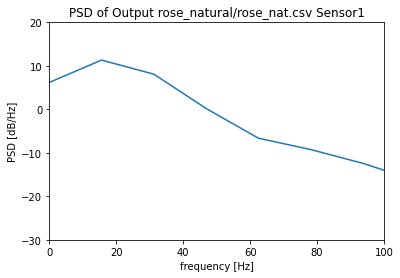

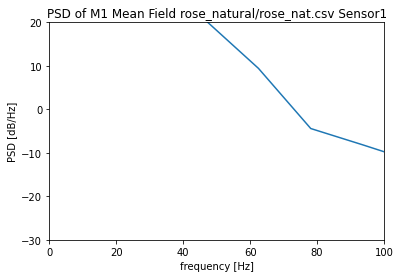

rose_natural/rose_nat.csv Sensor1 HFDA: 1.0032847392681843 Katz FD: 1.6221556052451138
rose_natural/rose_nat.csv 1


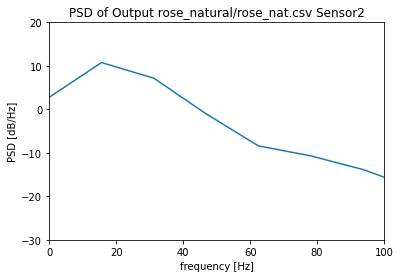

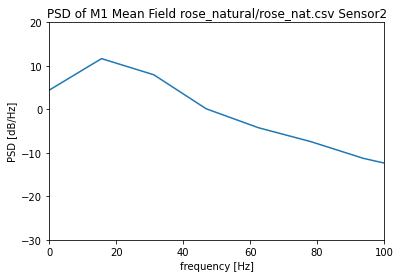

rose_natural/rose_nat.csv Sensor2 HFDA: 1.0028377946187692 Katz FD: 1.5788150884331384
rose_natural/rose_nat.csv 2


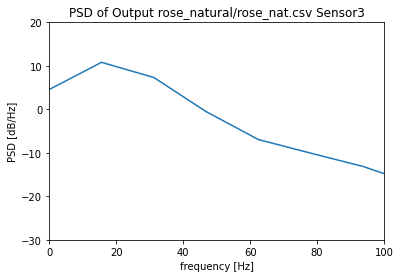

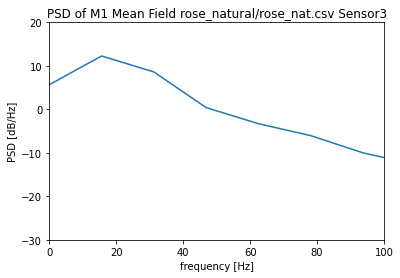

rose_natural/rose_nat.csv Sensor3 HFDA: 1.0037107380023662 Katz FD: 1.5797348833050082
rose_natural/rose_nat.csv 3


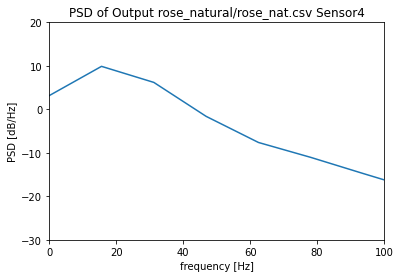

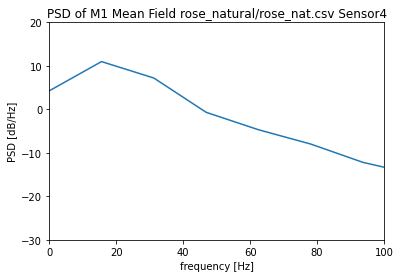

rose_natural/rose_nat.csv Sensor4 HFDA: 1.0029169408713892 Katz FD: 1.5663872591925698
rose_natural/rose_nat.csv 4


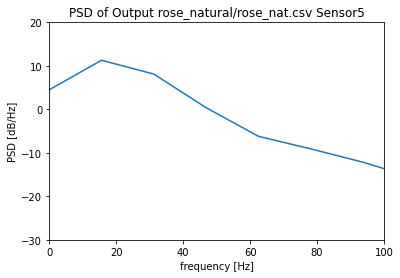

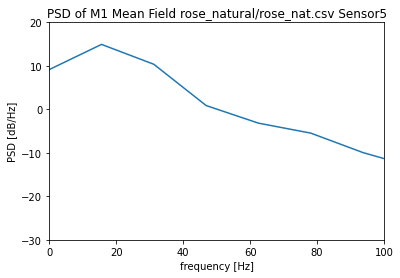

rose_natural/rose_nat.csv Sensor5 HFDA: 1.0035296781442864 Katz FD: 1.5859960189657574
rose_natural/rose_nat.csv 5


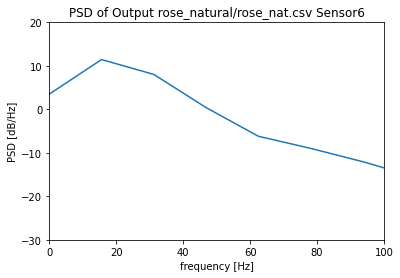

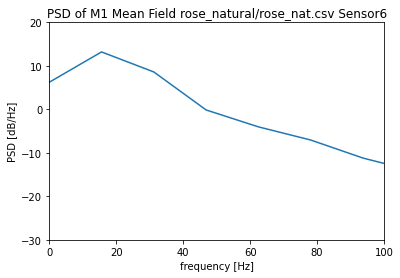

rose_natural/rose_nat.csv Sensor6 HFDA: 1.0039025657532228 Katz FD: 1.6058468344674972
rose_artificial/rose_art.csv 0


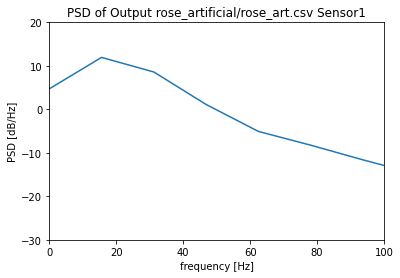

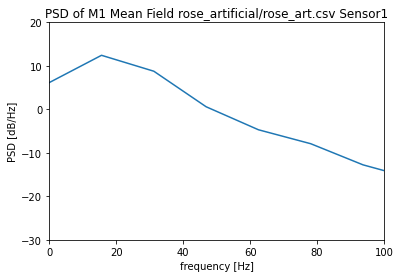

rose_artificial/rose_art.csv Sensor1 HFDA: 1.0037426639872449 Katz FD: 1.6184923628362626
rose_artificial/rose_art.csv 1


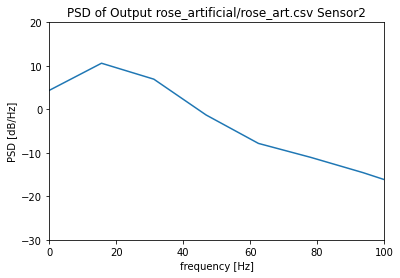

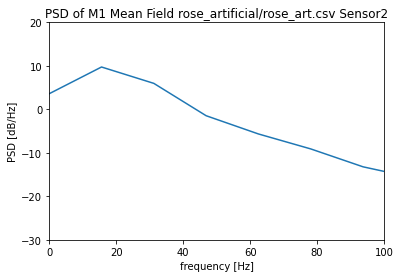

rose_artificial/rose_art.csv Sensor2 HFDA: 1.0025534202929225 Katz FD: 1.5873280821680005
rose_artificial/rose_art.csv 2


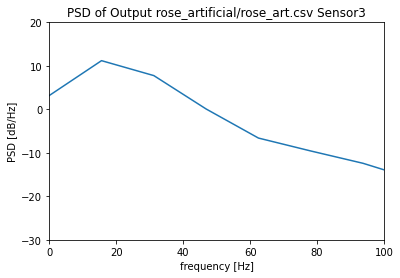

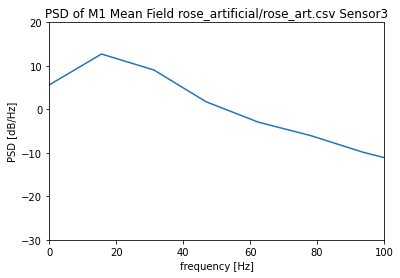

rose_artificial/rose_art.csv Sensor3 HFDA: 1.0035728682930074 Katz FD: 1.5869637410828568
rose_artificial/rose_art.csv 3


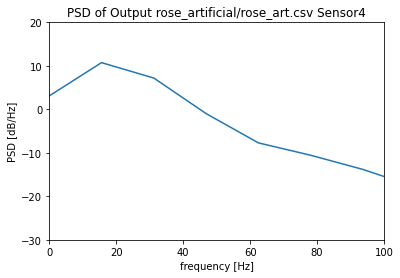

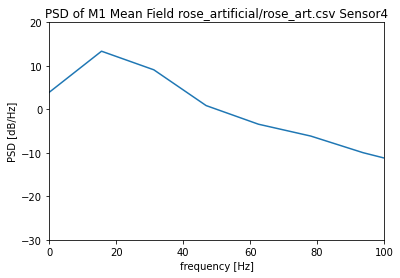

rose_artificial/rose_art.csv Sensor4 HFDA: 1.0031904489077164 Katz FD: 1.5765117240302697
rose_artificial/rose_art.csv 4


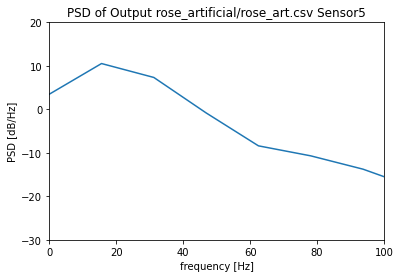

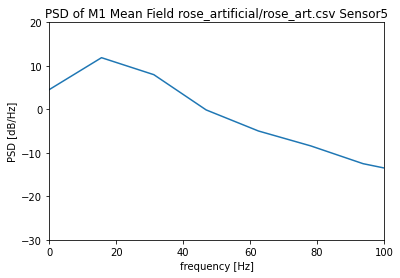

rose_artificial/rose_art.csv Sensor5 HFDA: 1.0031275893360188 Katz FD: 1.540478682680407
rose_artificial/rose_art.csv 5


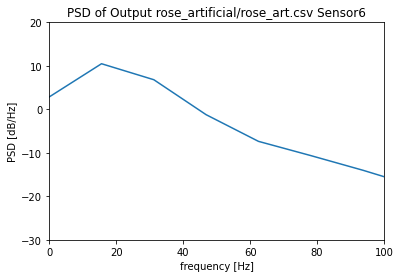

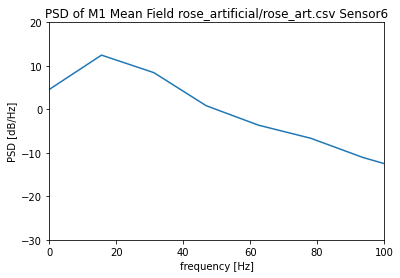

rose_artificial/rose_art.csv Sensor6 HFDA: 1.002954665245208 Katz FD: 1.5577607264797249
orange_natural/orange_natural.csv 0


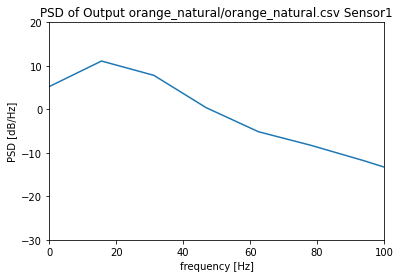

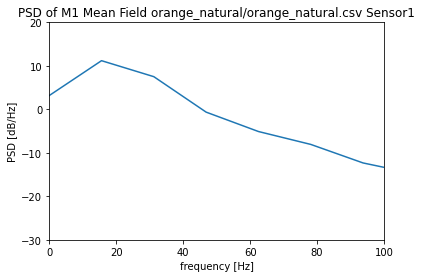

orange_natural/orange_natural.csv Sensor1 HFDA: 1.0032354439575655 Katz FD: 1.6412103730240888
orange_natural/orange_natural.csv 1


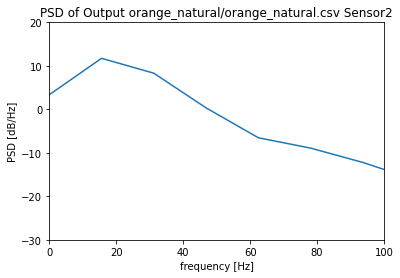

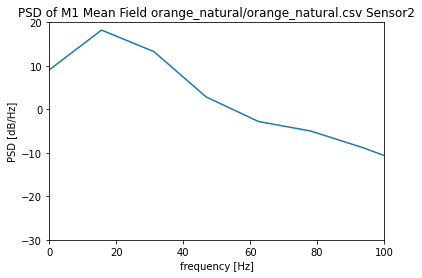

orange_natural/orange_natural.csv Sensor2 HFDA: 1.0032747872482914 Katz FD: 1.6353975971581698
orange_natural/orange_natural.csv 2


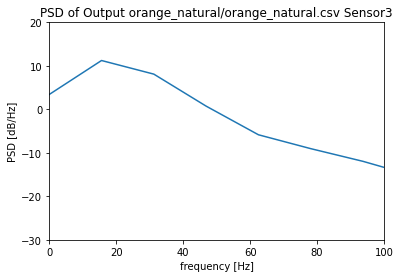

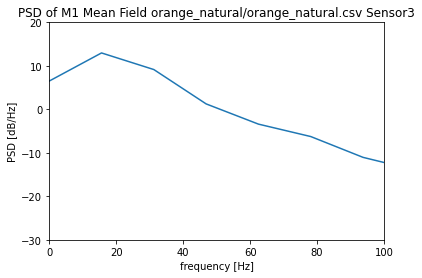

orange_natural/orange_natural.csv Sensor3 HFDA: 1.0038414224858163 Katz FD: 1.5791856431344264
orange_natural/orange_natural.csv 3


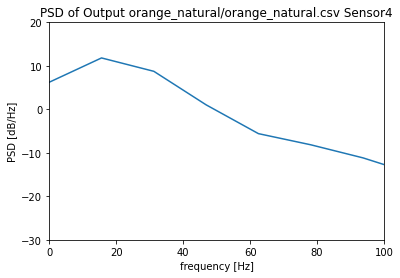

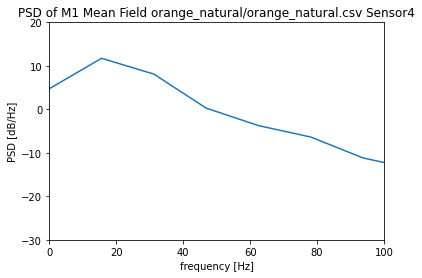

orange_natural/orange_natural.csv Sensor4 HFDA: 1.0032447353407803 Katz FD: 1.6330409602322478
orange_natural/orange_natural.csv 4


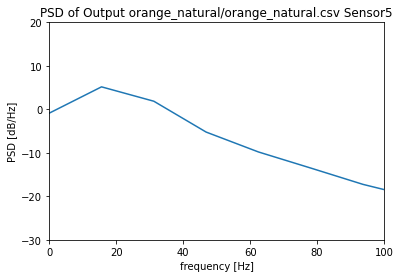

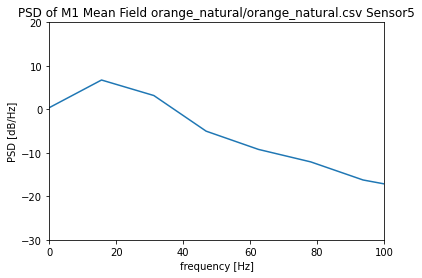

orange_natural/orange_natural.csv Sensor5 HFDA: 1.0043093635759357 Katz FD: 1.2823204427456765
orange_natural/orange_natural.csv 5


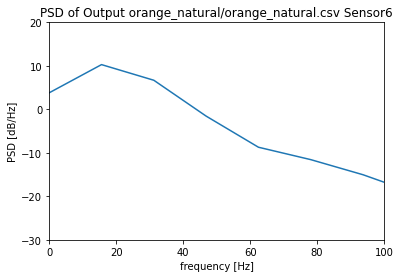

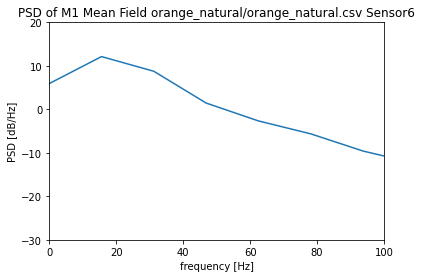

orange_natural/orange_natural.csv Sensor6 HFDA: 1.002802395728778 Katz FD: 1.5711471703193125
orange_artificial/orange_art.csv 0


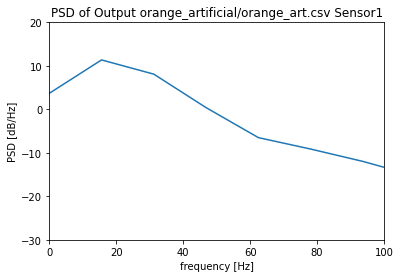

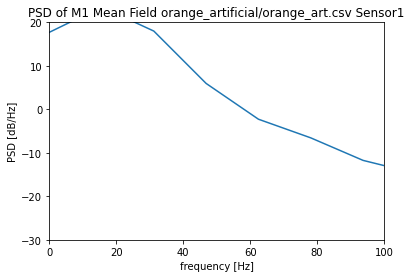

orange_artificial/orange_art.csv Sensor1 HFDA: 1.003434356166158 Katz FD: 1.5802883155136294
orange_artificial/orange_art.csv 1


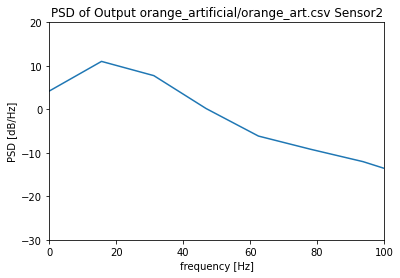

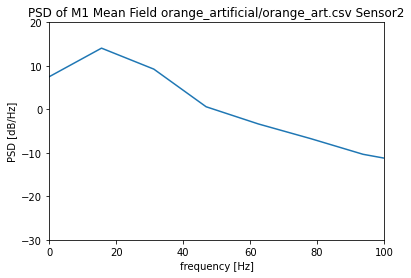

orange_artificial/orange_art.csv Sensor2 HFDA: 1.0034296301882741 Katz FD: 1.5919275135879056
orange_artificial/orange_art.csv 2


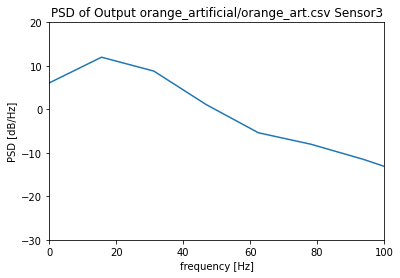

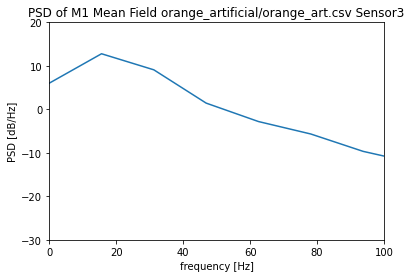

orange_artificial/orange_art.csv Sensor3 HFDA: 1.003422961850196 Katz FD: 1.6335459955684615
orange_artificial/orange_art.csv 3


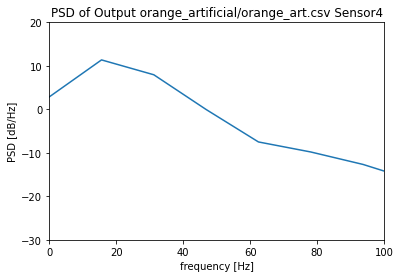

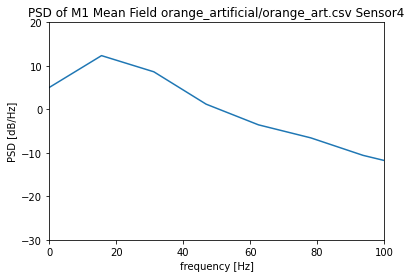

orange_artificial/orange_art.csv Sensor4 HFDA: 1.0037813793754666 Katz FD: 1.5842230206579593
orange_artificial/orange_art.csv 4


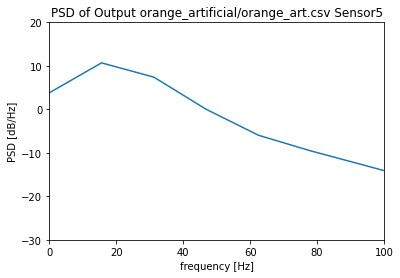

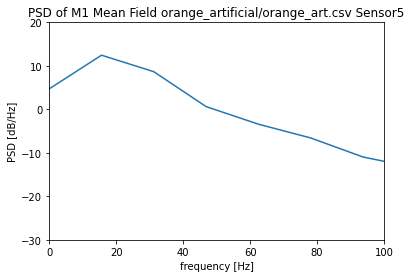

orange_artificial/orange_art.csv Sensor5 HFDA: 1.0038965082071578 Katz FD: 1.5809865353438008
orange_artificial/orange_art.csv 5


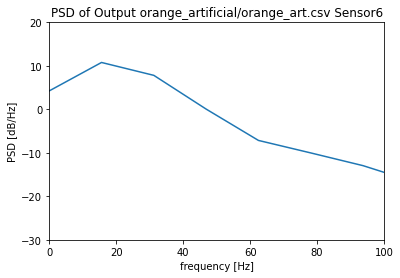

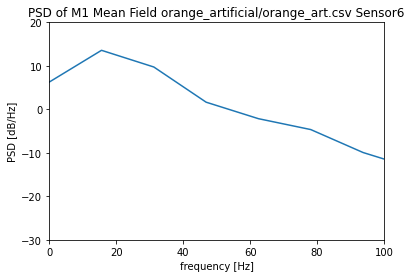

orange_artificial/orange_art.csv Sensor6 HFDA: 1.0048067798461828 Katz FD: 1.4933247120472992
lemon_natural/lemon_nat.csv 0


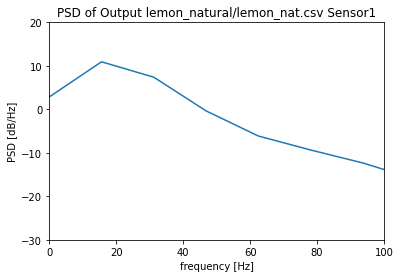

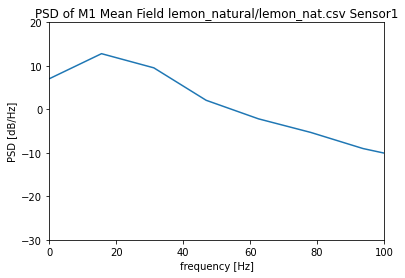

lemon_natural/lemon_nat.csv Sensor1 HFDA: 1.0033637882687925 Katz FD: 1.59595046561161
lemon_natural/lemon_nat.csv 1


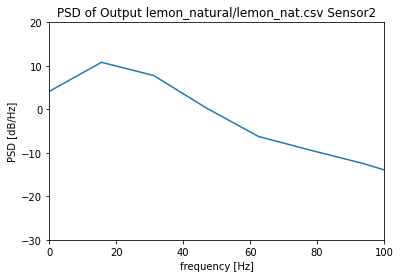

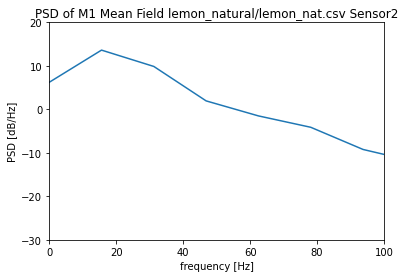

lemon_natural/lemon_nat.csv Sensor2 HFDA: 1.0043484983363218 Katz FD: 1.5559786206909194
lemon_natural/lemon_nat.csv 2


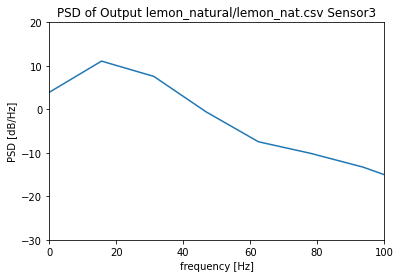

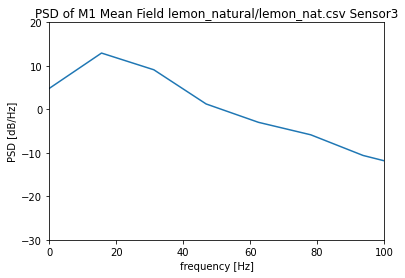

lemon_natural/lemon_nat.csv Sensor3 HFDA: 1.0028770919458208 Katz FD: 1.613381277984883
lemon_natural/lemon_nat.csv 3


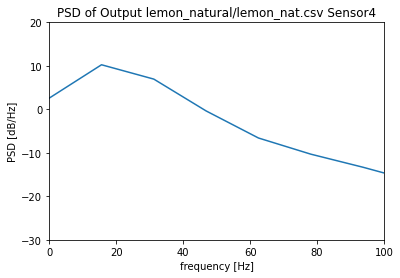

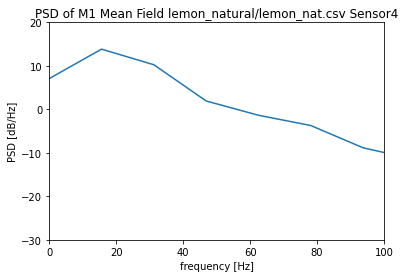

lemon_natural/lemon_nat.csv Sensor4 HFDA: 1.0046754964232396 Katz FD: 1.482846082275758
lemon_natural/lemon_nat.csv 4


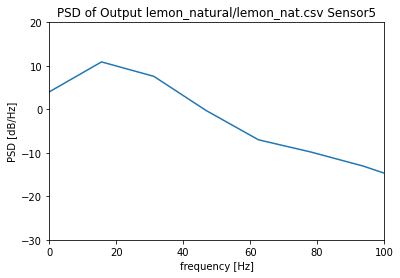

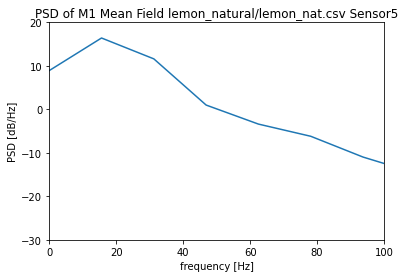

lemon_natural/lemon_nat.csv Sensor5 HFDA: 1.0036944084529709 Katz FD: 1.5753075693100616
lemon_natural/lemon_nat.csv 5


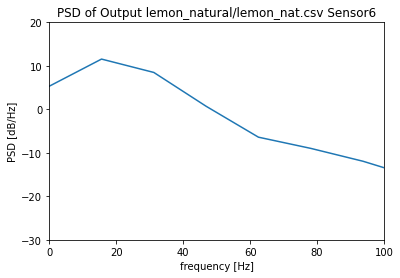

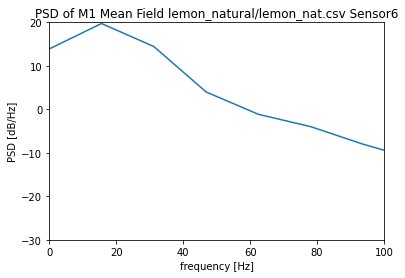

lemon_natural/lemon_nat.csv Sensor6 HFDA: 1.0038064013212185 Katz FD: 1.5951099518319622
lemon_artificial/lemon_art.csv 0


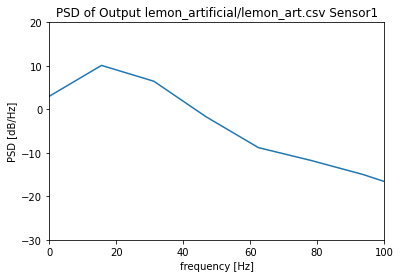

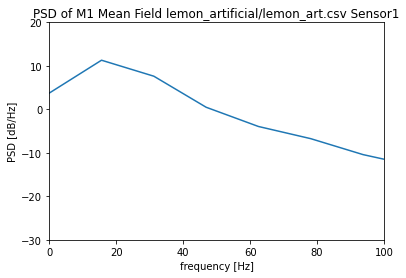

lemon_artificial/lemon_art.csv Sensor1 HFDA: 1.0026036834443983 Katz FD: 1.5566410159563022
lemon_artificial/lemon_art.csv 1


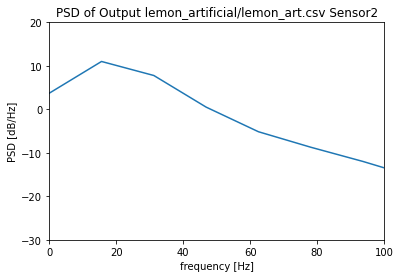

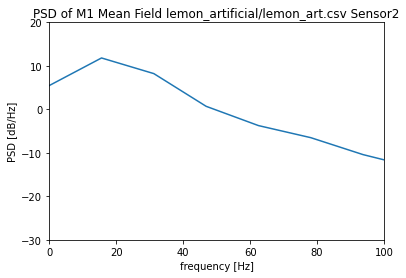

lemon_artificial/lemon_art.csv Sensor2 HFDA: 1.0038474377864757 Katz FD: 1.597861062613986
lemon_artificial/lemon_art.csv 2


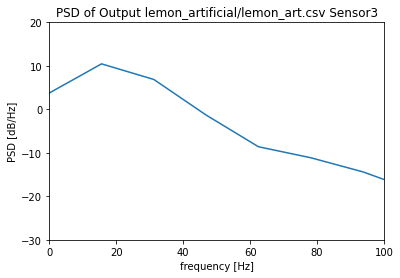

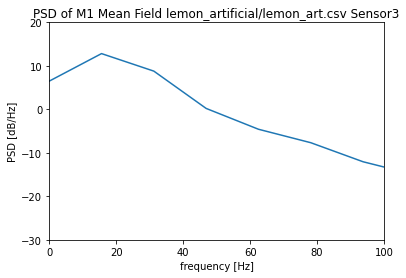

lemon_artificial/lemon_art.csv Sensor3 HFDA: 1.0025878949449094 Katz FD: 1.571567567837784
lemon_artificial/lemon_art.csv 3


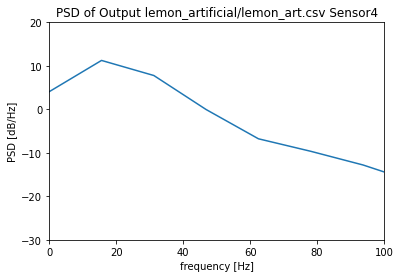

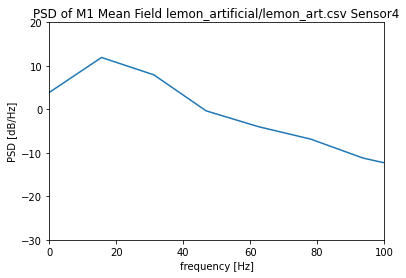

lemon_artificial/lemon_art.csv Sensor4 HFDA: 1.0028045683768299 Katz FD: 1.6093012350436597
lemon_artificial/lemon_art.csv 4


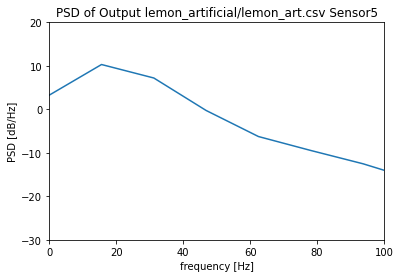

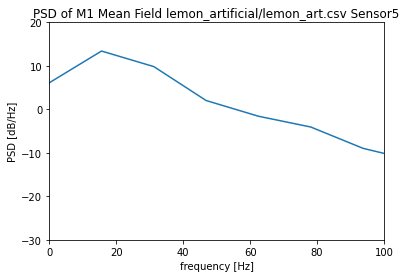

lemon_artificial/lemon_art.csv Sensor5 HFDA: 1.0044859322168682 Katz FD: 1.497547111419368
lemon_artificial/lemon_art.csv 5


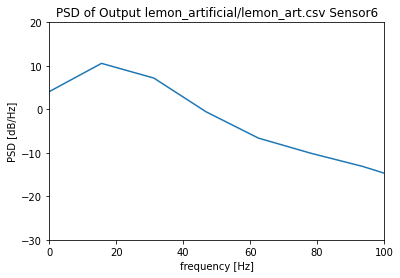

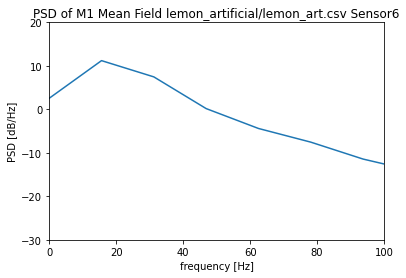

lemon_artificial/lemon_art.csv Sensor6 HFDA: 1.0032735660039176 Katz FD: 1.5797858231246305
apple_natural/apple_nat.csv 0


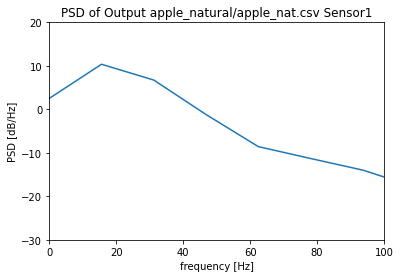

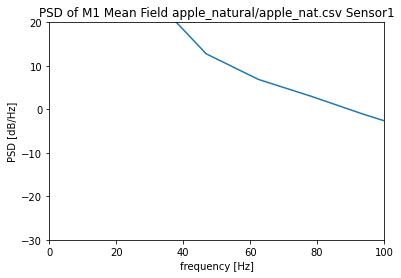

apple_natural/apple_nat.csv Sensor1 HFDA: 1.0037722100246194 Katz FD: 1.5403618261224423
apple_natural/apple_nat.csv 1


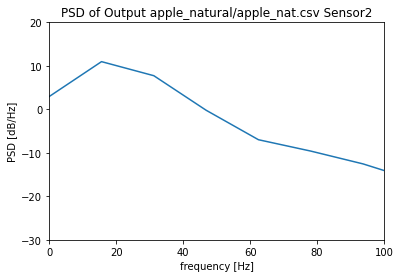

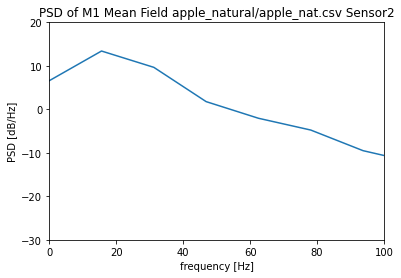

apple_natural/apple_nat.csv Sensor2 HFDA: 1.0040939988455893 Katz FD: 1.5464466160946264
apple_natural/apple_nat.csv 2


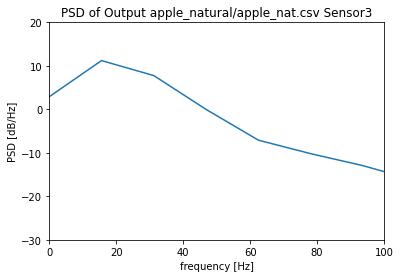

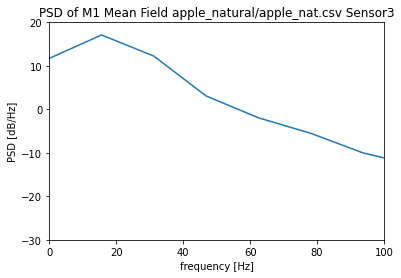

apple_natural/apple_nat.csv Sensor3 HFDA: 1.0036797376773603 Katz FD: 1.5593316483935622
apple_natural/apple_nat.csv 3


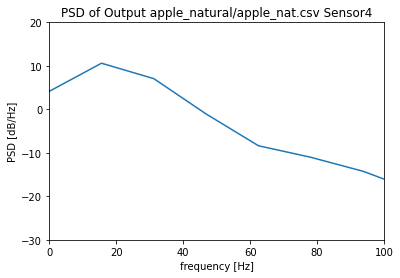

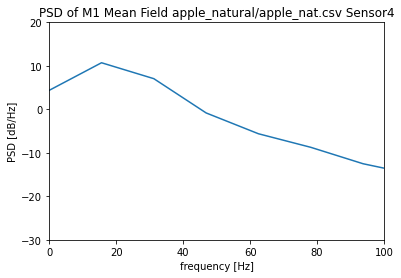

apple_natural/apple_nat.csv Sensor4 HFDA: 1.0029644341354351 Katz FD: 1.5831327023336803
apple_natural/apple_nat.csv 4


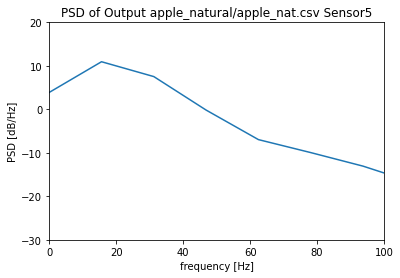

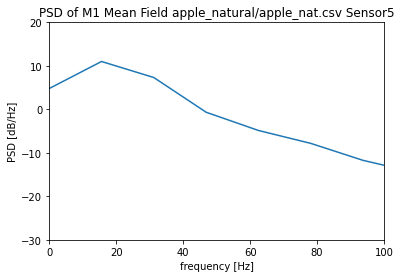

apple_natural/apple_nat.csv Sensor5 HFDA: 1.0031676705979355 Katz FD: 1.5836490358032795
apple_natural/apple_nat.csv 5


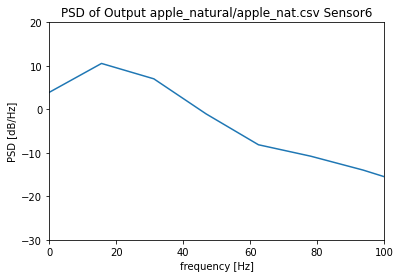

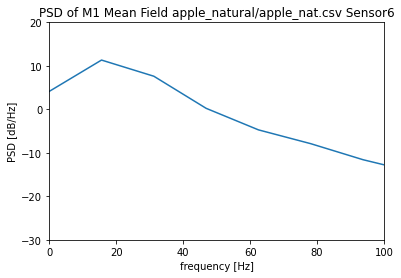

apple_natural/apple_nat.csv Sensor6 HFDA: 1.0029446795421861 Katz FD: 1.5699215237738227
apple_artificial/art_apple_day4.csv 0


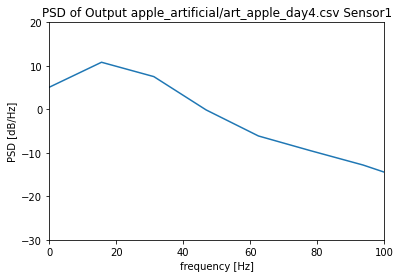

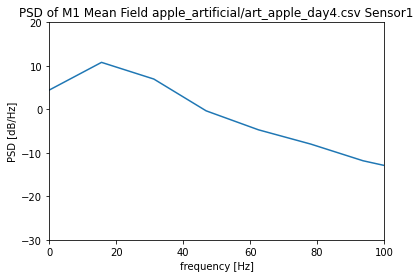

apple_artificial/art_apple_day4.csv Sensor1 HFDA: 1.0031339371706187 Katz FD: 1.5914158803773095
apple_artificial/art_apple_day4.csv 1


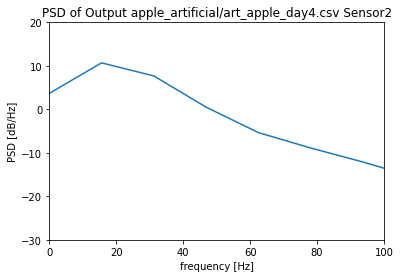

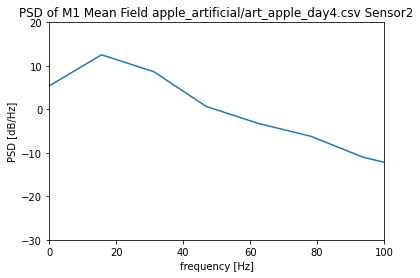

apple_artificial/art_apple_day4.csv Sensor2 HFDA: 1.0038527697890138 Katz FD: 1.5643310745665557
apple_artificial/art_apple_day4.csv 2


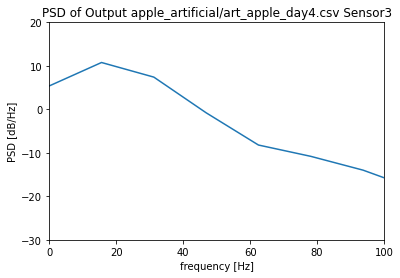

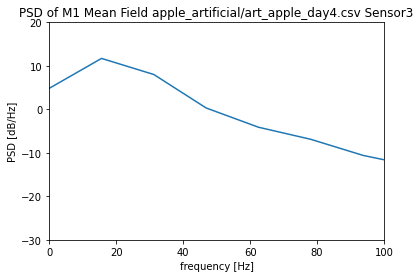

apple_artificial/art_apple_day4.csv Sensor3 HFDA: 1.0027830720178657 Katz FD: 1.5960767655942252
apple_artificial/art_apple_day4.csv 3


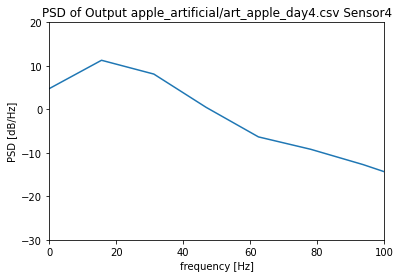

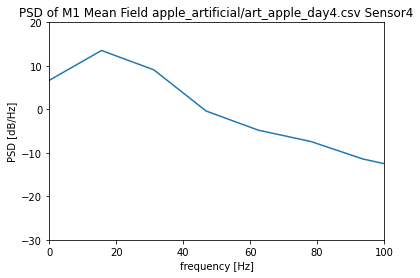

apple_artificial/art_apple_day4.csv Sensor4 HFDA: 1.0036570887263472 Katz FD: 1.5863733689707897
apple_artificial/art_apple_day4.csv 4


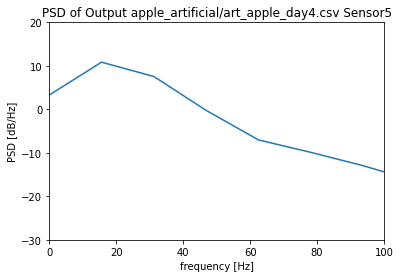

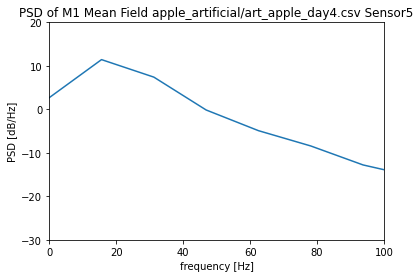

apple_artificial/art_apple_day4.csv Sensor5 HFDA: 1.003313702753148 Katz FD: 1.566662786614035
apple_artificial/art_apple_day4.csv 5


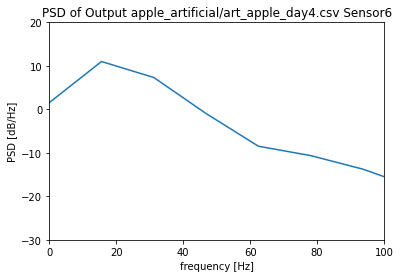

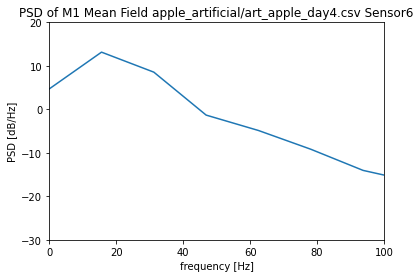

apple_artificial/art_apple_day4.csv Sensor6 HFDA: 1.0030213271697292 Katz FD: 1.5963331896227835


In [31]:
import hfda
import numpy as np
import antropy as ant# Katz fractal dimension
import pandas as pd
k_max = 10
csv_files = ['rose_natural/rose_nat.csv', 'rose_artificial/rose_art.csv', 'orange_natural/orange_natural.csv', 'orange_artificial/orange_art.csv', 'lemon_natural/lemon_nat.csv', 'lemon_artificial/lemon_art.csv', 'apple_natural/apple_nat.csv', 'apple_artificial/art_apple_day4.csv']
fd_hfda = {}
fd_katz = {}
for file in csv_files:
    df = pd.read_csv('csvs/'+file)

    for num in range(6):
        print(file, num)
        sensor = "Sensor"+str(num+1)
        L1 = LATERAL(15, np.random.uniform(0.5,1,15))
        learn()
        recording_cell = L1.AON.G1
        axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
        h.finitialize(-70*mV)
        h.continuerun(500*ms)
        welch(file, sensor)
        welchmultiple(file,sensor)
        fin_out = np.array(list(axon))
        D1 = hfda.measure(fin_out, k_max)
        D2 = ant.katz_fd(list(axon))
        try:
            fd_hfda[file].append(D1)
            fd_katz[file].append(D2)
        except KeyError:
            fd_hfda[file] = [D1]
            fd_katz[file] = [D2]
        print(file, sensor, "HFDA:", D1, "Katz FD:", D2)


# Scratchpad 

In [ ]:
name = 'DPC'
addendum=""
recording_cell = L1.DPC
cell_axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
cell_dend = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(300 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(cell_axon), line_width=1,legend_label=name+' axon '+addendum,line_color='black')
f.line(t, list(cell_dend), line_width=2,legend_label=name+' dendrite '+addendum,line_color='red', line_dash='dashed')
plt2.show(f)